### Portfolio Optimization using Efficient Frontier

### This is for educational purposes and to support my medium article:
### "Building Better Portfolios: Python Strategies for Risk Management and Returns" https://python.plainenglish.io/building-better-portfolios-python-strategies-for-risk-management-and-returns-a34003a24512


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import yfinance as yf
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

style.use('ggplot')

/Users/phitzi/PycharmProjects/Investment and Algorithmic Trading Notebooks/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Set up the parameters :
- The stocks of your portfolio
- The estimated returns of each stock
- Number of portfolios that we will simulate
- The risk-free rate
- The time frame for which we will get the data for
- The period for which we will get the data for ending today

In [2]:
tickers = ['MSFT', 'AMZN', 'TSLA', 'BAC', 'KO']
tickers_estimate_return = [0.1, 0.18, 0.22, 0.08, 0.11]
test_number_of_portfolios = 1000
risk_free = 0.019
timeframe = '1d'
days_of_simulation = 365
working_days_of_period = 252
end = dt.datetime.now()
start = end - dt.timedelta(days=days_of_simulation)
print(f'''Getting data from {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}''')

Getting data from 2023-03-18 to 2024-03-17


Download the adjusted close price from Yahoo Finance and convert to daily returns

In [3]:
prices = yf.download(tickers, period=timeframe, start=start, end=end)['Adj Close'].pct_change()
prices.columns.name = None  
prices.dropna(inplace=True)
prices = prices[tickers] #to ensure we got them in the proper order
prices.head(5)

[*********************100%%**********************]  5 of 5 completed


,MSFT,AMZN,TSLA,BAC,KO
Date,,,,,
2023-03-21,0.005694,0.029680,0.078199,0.030270,-0.004621
2023-03-22,-0.005442,-0.018984,-0.032544,-0.033228,-0.004476
2023-03-23,0.019722,0.000101,0.005598,-0.024240,-0.002165
2023-03-24,0.010480,-0.005876,-0.009416,0.006303,0.016355
2023-03-27,-0.014934,-0.000917,0.007353,0.049742,0.007389


Create a function that we get the prices, wrights and risk-free rate
and return the return, risk and sharpe ratio

In [4]:
def calc_portfolio_ratios(prices, weights, estimated_returns,risk_free):
    # estimated period returns
    estimated_period_return = np.sum(estimated_returns * weights)
    # risk (standard deviation) of portfolio
    cov_matrix = prices.cov() * working_days_of_period
    variance = weights.T.dot(cov_matrix).dot(weights)
    period_risk = np.sqrt(variance)
    # sharpe ratio
    period_sharpe_ratio = (estimated_period_return - risk_free) / period_risk
    return estimated_period_return, period_risk, period_sharpe_ratio

# calc_portfolio_ratios(prices,np.array([0.2,0.2,0.2,0.2,0.2]), np.array([0.1, 0.18, 0.22, 0.08, 0.11]),0.019)
calc_portfolio_ratios(prices,np.array([0,0,1,0,0]), np.array([0.1, 0.18, 0.22, 0.08, 0.11]),0.019)

(0.22, 0.48333333711935106, 0.41586206570801143)

Run the Monte Carlo simulation

In [5]:
portfolio_rtn = []
portfolio_risk = []
portfolio_sharpe = []
portfolio_weights = []

# run the simulations and add the results to lists
for portfolio in range(test_number_of_portfolios):
    # create a random set of weights and sum them up to 1
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    portfolio_weights.append(weights)
    #calc the return, risk and sharpe
    annual_return, annual_risk, sharpe_ratio = calc_portfolio_ratios(prices, weights, tickers_estimate_return, risk_free)
    portfolio_rtn.append(annual_return)
    portfolio_risk.append(annual_risk)
    portfolio_sharpe.append(sharpe_ratio)

For better understanding of the results further on, we will add also simulation of portfolios having only one stock

In [6]:
for i, t in enumerate(tickers):
    weights = np.zeros(len(tickers))
    weights[i] = 1
    portfolio_weights.append(weights)
    annual_return, annual_risk, sharpe_ratio = calc_portfolio_ratios(prices, weights, tickers_estimate_return, risk_free)
    portfolio_rtn.append(annual_return)
    portfolio_risk.append(annual_risk)
    portfolio_sharpe.append(sharpe_ratio) 

We will create a dataframe with the results and weights

In [11]:
portfolio_risk = np.array(portfolio_risk)
portfolio_sharpe = np.array(portfolio_sharpe)
portfolio_return = np.array(portfolio_rtn)
portfolio_metrics = [portfolio_rtn, portfolio_risk, portfolio_sharpe]

df_portfolio_metrics = pd.DataFrame(portfolio_metrics).T
df_portfolio_metrics.columns=['Est.Returns', 'Risk', 'Sharpe']

df_weights = pd.DataFrame(portfolio_weights)
df_weights.columns = tickers
df_simulations = df_portfolio_metrics.join(df_weights)
df_simulations.head(5)

,Est.Returns,Risk,Sharpe,MSFT,AMZN,TSLA,BAC,KO
0,0.129994,0.180888,0.613605,0.218611,0.121753,0.204237,0.293634,0.161765
1,0.104374,0.173083,0.493254,0.485706,0.064478,0.057908,0.388411,0.003496
2,0.122598,0.204623,0.506286,0.343321,0.027902,0.233360,0.386399,0.009019
3,0.130219,0.166566,0.667718,0.258375,0.294587,0.074261,0.199563,0.173213
4,0.136895,0.215162,0.547935,0.168959,0.059422,0.311878,0.329393,0.130347


Create a dataframe for better visibility of the metrics of the simulations for 
- Minimum Risk
- Maximum Return
- Maximum Sharpe Ratio
- Each stock separately 

In [13]:
#keep the index of the min risk, max return, max sharpe and individual stocks to be used in plot
min_risk_idx = df_simulations['Risk'].idxmin()
max_return_idx  = df_simulations['Est.Returns'].idxmax()
max_sharpe_idx = df_simulations['Sharpe'].idxmax()
tickers_idx = []
for i, t in enumerate(tickers):
    tickers_idx.append(df_simulations[t].idxmax())
#create a dataframe for better visibility of the results 
df_results = df_simulations.iloc[[min_risk_idx, max_return_idx, max_sharpe_idx] + tickers_idx]
df_results.insert(0, 'Description', ['Min Risk', 'Max Return', 'Max Sharpe'] + tickers)
df_results

,Description,Est.Returns,Risk,Sharpe,MSFT,AMZN,TSLA,BAC,KO
361,Min Risk,0.113252,0.116741,0.807366,0.101568,0.033010,0.060796,0.157675,0.646951
1002,Max Return,0.220000,0.483333,0.415862,0.000000,0.000000,1.000000,0.000000,0.000000
607,Max Sharpe,0.129604,0.125092,0.884186,0.054415,0.215397,0.048036,0.007103,0.675050
1000,MSFT,0.100000,0.223922,0.361733,1.000000,0.000000,0.000000,0.000000,0.000000
1001,AMZN,0.180000,0.302707,0.531868,0.000000,1.000000,0.000000,0.000000,0.000000
1002,TSLA,0.220000,0.483333,0.415862,0.000000,0.000000,1.000000,0.000000,0.000000
1003,BAC,0.080000,0.252760,0.241336,0.000000,0.000000,0.000000,1.000000,0.000000
1004,KO,0.110000,0.128714,0.706994,0.000000,0.000000,0.000000,0.000000,1.000000


Plot the efficient frontier and add the stars to the portfolios with the highest metrics

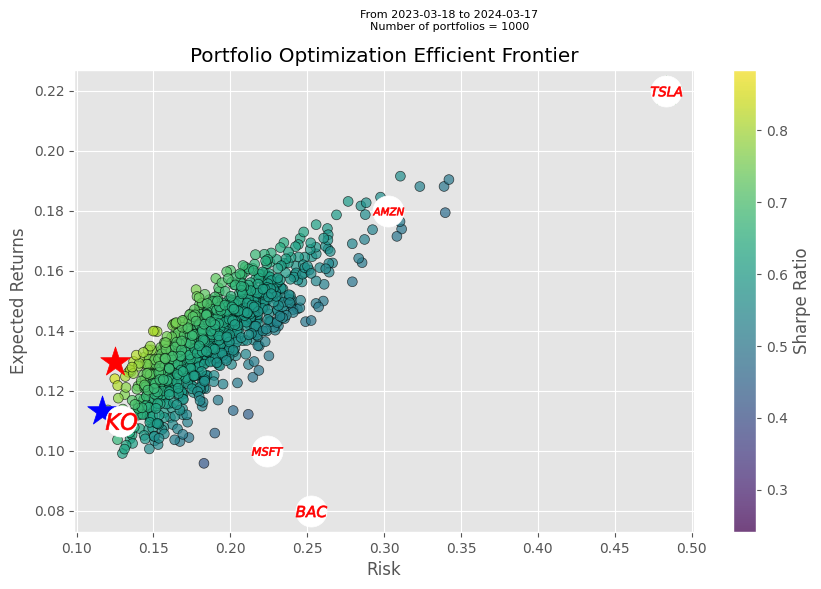

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter('Risk', 'Est.Returns', c='Sharpe', cmap='viridis', edgecolors='k', data=df_simulations, alpha=0.7, s=50)
plt.colorbar(label = "Sharpe Ratio")
plt.xlabel('Risk')
plt.ylabel('Expected Returns')

plt.title('Portfolio Optimization Efficient Frontier')
plt.suptitle(f'From {start.strftime("%Y-%m-%d")} to {end.strftime("%Y-%m-%d")}\nNumber of portfolios = {test_number_of_portfolios}', fontsize=8)
#add a star to Max Sharpe
plt.scatter(df_simulations.iloc[max_sharpe_idx]['Risk'], df_simulations.iloc[max_sharpe_idx]['Est.Returns'], marker='*', s=500, c='red')
#add a star to Max Return
plt.scatter(df_simulations.iloc[max_return_idx]['Risk'], df_simulations.iloc[max_return_idx]['Est.Returns'], marker='*', s=500, c='green')
#add a star to Min Risk
plt.scatter(df_simulations.iloc[min_risk_idx]['Risk'], df_simulations.iloc[min_risk_idx]['Est.Returns'], marker='*', s=500, c='blue')
#add the individual stocks
for i, t in enumerate(tickers):
    plt.scatter(df_simulations.iloc[tickers_idx[i]]['Risk'], df_simulations.iloc[tickers_idx[i]]['Est.Returns'], marker='o', s=500, c='white')
    plt.scatter(df_simulations.iloc[tickers_idx[i]]['Risk'], df_simulations.iloc[tickers_idx[i]]['Est.Returns'], marker=f'${t}$', s=500, c='red')
plt.show()